In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
try:
    import cplex
except:
    !pip install cplex
    import cplex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 18.2 MB/s eta 0:00:00


## Reading from Datasource

In [3]:
##### !!!! Please replace and point towards correct path before starting #
# Input file
input_file_prices='./sample_data/adjclose_2020_2021.csv' # path to close_2020_2021 file

# path to close_2023_2024 file'
input_file_prices_new='./sample_data/adjclose_2023_2024.csv'

# path to stock sectors
stock_sectors='./sample_data/stocks_info.csv'


def read_file(file_path):
  return pd.read_csv(file_path)

def get_stocks_sector(file_path):
  stocks_sector = read_file(file_path)
  #stocks_sector
  sectors = stocks_sector.groupby("sector").apply(lambda x: x.index.tolist())
  return sectors.to_dict()


df = read_file(input_file_prices)
df_new = read_file(input_file_prices_new)
sectors = get_stocks_sector(stock_sectors)

<ipython-input-3-847d9be1812d>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sectors = stocks_sector.groupby("sector").apply(lambda x: x.index.tolist())


# Strategies
 For strategies 3, 4, and 5 include mathematical formulation of optimization problem in report and/or in notebook

In [4]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices,r_rf):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

In [5]:
#### Helper Function ######

commission_rate=0.005
num_stocks =30

# Annual risk-free rate for years 2020-2021 is 1.5%
r_rf = 0.015

#recalculate the balance: before cash+before portfolio - after portfolio - commission
def calculate_balance(cash_init, x_optimal, x_init, cur_prices):
    commission_total = np.sum(np.abs(x_optimal-x_init) * cur_prices)*commission_rate
    cash_optimal = cash_init+ np.dot(x_init,cur_prices) - np.dot(x_optimal,cur_prices) -commission_total
    return cash_optimal


#if cash_optimal < 0 after optimization then deducting each entry with same amount
def handle_insufficient_budget(x_init, x_optimal, cur_prices, cash_optimal, cash_init):
    # deducted to those x_optimal[i] > 0, keep it to 0 if x_optimal[i]=0
    # if -1.2 then sell more to -2
    pos_num_shares = np.sum(x_optimal > 0)

    # deducted_amount = cash_optimal / pos_num_shares
    # np.where(x_optimal > 0, )
    deducted_shares = np.floor([cash_optimal / pos_num_shares]*num_stocks /cur_prices)
    #print("deducted shares:", deducted_shares)
    x_optimal = np.where(x_optimal > 0, x_optimal+deducted_shares, 0)

    return x_optimal, calculate_balance(cash_init, x_optimal,x_init, cur_prices)

def get_num_shares_from_weights(weights, total_asset, cur_prices):
    x_optimal = np.floor(weights * total_asset / cur_prices)
    return x_optimal


In [6]:
##Optimized solution
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices,r_rf):
    total_asset=np.dot(x_init, cur_prices)+cash_init
    optimized_weight=np.array([1/num_stocks] * num_stocks)

    x_optimal = get_num_shares_from_weights(optimized_weight, total_asset, cur_prices)
    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)

    return x_optimal, cash_optimal

In [7]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices,r_rf):
    #create a cplex instance
    cpx = cplex.Cplex()
    cpx.set_problem_type(cplex.Cplex.problem_type.QP)  # Quadratic as Q^TWQ
    cpx.objective.set_sense(cpx.objective.sense.minimize)  # Minimize variance

    #Add linear constraint and variables
    variables = [f"w_{i}" for i in range(num_stocks)]
    lb = [0] * num_stocks
    ub = [1] * num_stocks
    cpx.variables.add(names=variables, lb=lb, ub=ub)

    # linear_constraints: the sum of variables
    # ind: the variable names
    # val: the coefficient
    cpx.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=variables, val=[1] * num_stocks)],
        senses=["E"],  # "E" means equality constraint
        rhs=[1]  # Sum of weights must equal 1
    )


    #Add quadratic part
    #CPLEX solver soling for 1/2 Q^TWQ
    qmat = []
    for i in range(num_stocks):
        qmat.append([[j for j in range(num_stocks)], [Q[i, j]  if i == j else Q[i, j] for j in range(num_stocks)]])

    cpx.objective.set_quadratic(qmat)


    # Solve the problem with additional parameters
    cpx.set_log_stream(None)
    cpx.set_error_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()

    # Get and print results
    optimized_weight = np.array(cpx.solution.get_values())
#     print("optimized_weight total:", np.sum(optimized_weight))

    total_assets=np.dot(x_init, cur_prices) + cash_init
#     print("total_assets:", total_assets)
    x_optimal=get_num_shares_from_weights(optimized_weight, total_assets, cur_prices)

    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)

    return x_optimal, cash_optimal

In [9]:
def strat_max_return(x_init, cash_init, mu, Q, cur_prices,r_rf):
    cpx = cplex.Cplex()

    cpx.set_problem_type(cplex.Cplex.problem_type.LP)
    cpx.objective.set_sense(cpx.objective.sense.maximize)

    variables = [f"w_{i}" for i in range(num_stocks)]
    lb = [0] * num_stocks
    ub = [1] * num_stocks
    # all w_i > 0 and w_i <1
    # C stands for continuous
    cpx.variables.add(names=variables, lb=lb, ub=ub, types=['C']*num_stocks)

    cpx.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=variables, val=[1] * num_stocks)],
        senses=["E"],  # "E" means equality constraint
        rhs=[1]  # Sum of weights must equal 1
    )

    #Usage: cpx.objective.set_linear([('w_0', 0.05), ('w_1', 0.12), ('w_2', 0.08)])
    #cpx.objective.set_linear(mu)
    cpx.objective.set_linear(list(zip(variables, mu)))
    cpx.set_log_stream(None)
    cpx.set_error_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)

    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()

    optimized_weight = np.array(cpx.solution.get_values())
#   print("optimized_weight total:", np.sum(optimized_weight))

    total_assets=np.dot(x_init, cur_prices) + cash_init
#   print("total_assets:", total_assets)
    x_optimal=get_num_shares_from_weights(optimized_weight, total_assets, cur_prices)
#   print("x_optimal:", x_optimal)

    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)


    return x_optimal, cash_optimal

In [10]:
### Strategy 5 Helper Function: Max Shape Ratio #######
def get_max_sharpe(mu, Q, r_rf):
    """
    Solve the maximum Sharpe ratio problem in CPLEX using the
    re-parameterized approach:
      min y^T Q y
      s.t. sum_i((mu_i - r_rf/252) * y_i) = 1
           sum_i(y_i) = kappa
           y_i >= 0, kappa >= small positive.

    The solution is y*, kappa*, and the portfolio weights are w_i = y_i / kappa.
    We also return the maximum Sharpe ratio = 1/sqrt(y^T Q y).

    Parameters
    ----------
    mu : list or np.ndarray
        Length-n array of expected (annual) returns.
    Q : list of lists or np.ndarray
        (n x n) covariance matrix of returns.
    r_rf : float
        Risk-free rate (annual). The code uses (r_rf/252) in the constraint
        if you want to interpret the Sharpe ratio on a daily basis.

    Returns
    -------
    w_ms : np.ndarray
        The optimal portfolio weights that maximize the Sharpe ratio.
    max_sharpe : float
        The maximum Sharpe ratio, i.e. 1 / sqrt(y^T Q y).
    """
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)

    # Number of assets
    n = len(mu)

    # 1) Linear objective coefficients => 0 for all variables (only a quadratic term).
    c = [0.0]*(n + 1)

    # 2) Variable bounds => y_i >= 0, kappa >= 1e-6
    lb = [0.0]*n + [1e-6]
    ub = [cplex.infinity]*(n+1)

    # --------------------------------------------------------------
    # 3) Two constraints:
    #   (a) sum_i((mu_i - r_rf/252) * y_i) = 1
    #   (b) sum_i(y_i) - kappa = 0
    # --------------------------------------------------------------
    Atilde = []
    for i in range(n):
        Atilde.append([
            [0, 1],                       # rows
            [(mu[i] - r_rf / 252.0), 1.0] # coefficients in those two rows
        ])

    # The (n+1)-th variable is kappa, so row 0 -> 0.0, row 1 -> -1.0
    Atilde.append([[0, 1], [0.0, -1.0]])

    my_sense = "EE"         # two equality constraints
    rhs_vals = [1.0, 0.0]   # right-hand sides

    cpx.linear_constraints.add(rhs=rhs_vals, senses=my_sense)

    var_names = [f"y_{i}" for i in range(n)] + ["kappa"]
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=Atilde, names=var_names)

    # --------------------------------------------------------------
    # 4) Quadratic objective: y^T Q y
    # --------------------------------------------------------------
    Qmat = []
    for i in range(n):
        Qmat.append([list(range(n)), Q[i]])  # row for y_i
    # For kappa (the last var), we have zero row
    Qmat.append([[n], [0.0]])

    cpx.objective.set_quadratic(Qmat)

    # --------------------------------------------------------------
    # 5) Solve the model
    # --------------------------------------------------------------
    cpx.set_log_stream(None)
    cpx.set_error_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.set_results_stream(None)

    cpx.solve()

    # --------------------------------------------------------------
    # 6) Retrieve the solution
    # --------------------------------------------------------------
    numcols = cpx.variables.get_num()  # should be n+1
    x_opt = [cpx.solution.get_values(j) for j in range(numcols)]

    y_opt = x_opt[:n]
    kappa_opt = x_opt[n]

    # Portfolio weights: w_i = y_i / kappa
    w_ms = np.array([y_i / kappa_opt for y_i in y_opt])

    # Calculate y^T Q y
    #  => We'll do a straightforward summation
    yQy = 0.0
    for i in range(n):
        for j in range(n):
            yQy += y_opt[i] * Q[i][j] * y_opt[j]

    # Maximum Sharpe ratio = 1 / sqrt(y^T Q y)
    max_sharpe = 1.0 / math.sqrt(yQy)

    return w_ms, max_sharpe

In [11]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices, r_rf):

   w_star, max_sr = get_max_sharpe(mu, Q, r_rf)

   total_assets = np.dot(x_init, cur_prices) + cash_init
   x_optimal=get_num_shares_from_weights(w_star, total_assets, cur_prices)

   cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)


   return x_optimal, cash_optimal

In [12]:
def strat_max_return_sector_constraints(x_init, cash_init, mu, Q, cur_prices,r_rf):
    cpx = cplex.Cplex()

    cpx.set_problem_type(cplex.Cplex.problem_type.LP)
    cpx.objective.set_sense(cpx.objective.sense.maximize)

    variables = [f"w_{i}" for i in range(num_stocks)]
    lb = [0] * num_stocks
    ub = [1] * num_stocks
    # all w_i > 0 and w_i <1
    # C stands for continuous
    cpx.variables.add(names=variables, lb=lb, ub=ub, types=['C']*num_stocks)

    cpx.linear_constraints.add(
        lin_expr=[cplex.SparsePair(ind=variables, val=[1] * num_stocks)],
        senses=["E"],  # "E" means equality constraint
        rhs=[1]  # Sum of weights must equal 1
    )


    ##### Sector constraints #####
    # Apply sector constrains, each sector < 25% of total portfolios
    for sector_name, stock_indices in sectors.items():
      sector_vars = [f"w_{i}" for i in stock_indices]
      #each sector < 25%
      cpx.linear_constraints.add(
          lin_expr=[cplex.SparsePair(ind=sector_vars, val=[1] * len(stock_indices))],
          senses=["L"],  # Less than or equal constraint
          rhs=[0.25]  # Maximum sector allocation is 25%
      )
      #each sector > 0%
      cpx.linear_constraints.add(
          lin_expr=[cplex.SparsePair(ind=sector_vars, val=[1] * len(stock_indices))],
          senses=["G"],
          rhs=[0]
      )


    #Usage: cpx.objective.set_linear([('w_0', 0.05), ('w_1', 0.12), ('w_2', 0.08)])
    #cpx.objective.set_linear(mu)
    cpx.objective.set_linear(list(zip(variables, mu)))
    cpx.set_log_stream(None)
    cpx.set_error_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_results_stream(None)

    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    cpx.solve()

    optimized_weight = np.array(cpx.solution.get_values())
#   print("optimized_weight total:", np.sum(optimized_weight))

    total_assets=np.dot(x_init, cur_prices) + cash_init
#   print("total_assets:", total_assets)
    x_optimal=get_num_shares_from_weights(optimized_weight, total_assets, cur_prices)
#   print("x_optimal:", x_optimal)

    cash_optimal = calculate_balance(cash_init,x_optimal,x_init, cur_prices)


    return x_optimal, cash_optimal

In [13]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_return', 'strat_max_Sharpe','strat_max_return_sector_constraints']
strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Expected Return Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Maximum Expected Return Portfolio Sector Constraints']

N_strat = len(strategy_functions)
#N_strat = 1  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_return, strat_max_Sharpe,strat_max_return_sector_constraints]

# Data loading and initialization of portfolios

In [14]:
# # import os

# # # List all files and directories in the current working directory
# # files = os.listdir('./sample_data/')
# # print(files)

# # Input file
# #input_file_prices='MIE1622H_Assign1_data/adjclose_2020_2021.csv' # path to close_2020_2021 file
# input_file_prices='./sample_data/adjclose_2020_2021.csv' # path to close_2020_2021 file

# # Read data into a dataframe
# df = pd.read_csv(input_file_prices)


In [15]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [16]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1

day_ind_start0 = 0
if '2021' in input_file_prices:
    day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
elif '2022' in input_file_prices:
    day_ind_end0 = len(np.where(dates_array[:,0]==2020)[0])

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)
# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [17]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3447, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19385, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)


Initial portfolio value = $ 1000016.96



# Running computations and printing results

In [18]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

# weight of each portfolio over time
# portfolio_allocation[i][j][k] is the weight of portfolio k at day j with strategy i
portfolio_allocation = np.zeros((N_strat, N_days, num_stocks),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if '2020' in input_file_prices:
      if dates_array[0, 0] == 20:
         cur_year  = 20 + math.floor(period/7)
      else:
         cur_year  = 2020 + math.floor(period/7)

   elif '2021' in input_file_prices:
      if dates_array[0, 0] == 21:
         cur_year  = 21 + math.floor(period/7)
      else:
         cur_year  = 2021 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, r_rf)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0 :
         x[strategy, period-1], cash[strategy, period-1] = handle_insufficient_budget(curr_positions, x[strategy, period-1], cur_prices, cash[strategy, period-1], curr_cash)



      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))

      # Compute portfolio weight over time
      # print("data price:", data_prices[day_ind_start:day_ind_end+1,:])
      # print("x:", x[strategy, period-1])
      # print("nemerator:", data_prices[day_ind_start:day_ind_end+1,:]* x[strategy, period-1])
      # # print("array2: ", np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) )
      # print("denominator:", np.reshape(np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]), (p_values.size,1)))
      # print("result:", data_prices[day_ind_start:day_ind_end+1,:]* x[strategy, period-1] / np.reshape(np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]), (p_values.size,1)) )

      # Calculate the total worth of each stock on each day
      # divided by total stock worth to get weight
      portfolio_allocation[strategy][day_ind_start:day_ind_end+1] = data_prices[day_ind_start:day_ind_end+1,:]* x[strategy, period-1] / np.reshape(np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]), (p_values.size,1))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000016.96, value end = $ 887595.87, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 990729.37, value end = $ 904107.49, cash account = $1009.28
  Strategy "Minimum Variance Portfolio", value begin = $ 990206.96, value end = $ 906946.33, cash account = $551.54
  Strategy "Maximum Expected Return Portfolio", value begin = $ 990066.86, value end = $ 917076.82, cash account = $63.59
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990068.88, value end = $ 918901.84, cash account = $470.80
  Strategy "Maximum Expected Return Portfolio Sector Constraints", value begin = $ 990068.23, value end = $ 888642.28, cash account = $338.49

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 935621.22, value end = $ 918221.82, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 944022.37, value 

# Plot results

**Portfolio Value over time 2020-2021 for all 5 stategies**

In [19]:
# function to plot portfolio value
def plot_portfolio_value(portfolio_value, dates_array_plot,time_range):
  # Create the plot

  plt.plot(dates_array_plot, portfolio_value[0], label="Buy And Hold", color="blue" )
  plt.plot(dates_array_plot, portfolio_value[1], label="Equally Weighted Portfolio", color="orange" )
  plt.plot(dates_array_plot, portfolio_value[2], label="Minimum Variance Portfolio", color="green" )
  plt.plot(dates_array_plot, portfolio_value[3], label="Maximum Expected Return Portfolio", color="Red" )
  plt.plot(dates_array_plot, portfolio_value[4], label="Maximum Sharpe Ratio Portfolio", color="purple" )
  plt.plot(dates_array_plot, portfolio_value[5], label="Maximum Expected Return Portfolio Sector Contraint", color="yellow" )

  # Add labels and title
  plt.xlabel("Date")
  plt.ylabel("Portfolio Value ($)")
  title = "Portfolio Value "+time_range
  plt.title(title)

  plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2 months
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))

  # Rotate labels for better readability
  plt.xticks(rotation=45)
  plt.grid(True)
  #plt.legend()
  plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1))

  # Show the plot
  plt.show()


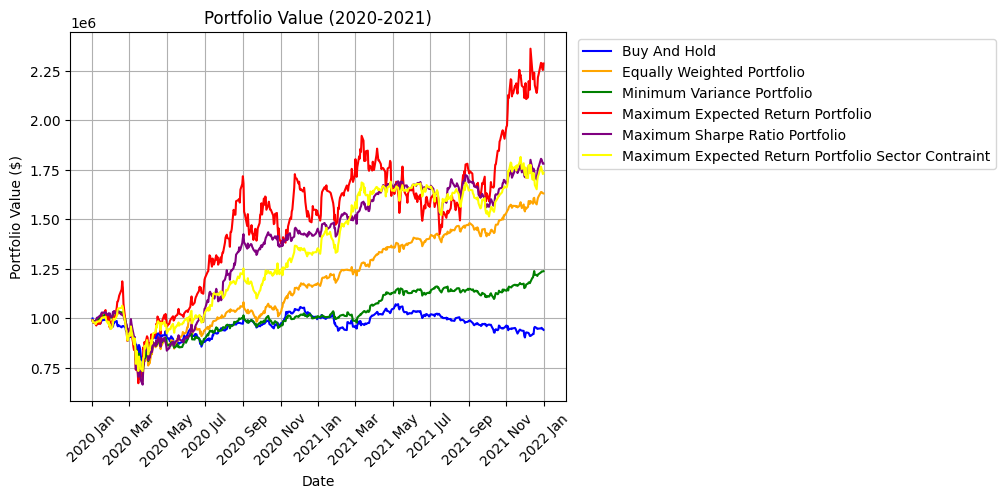

In [20]:
# Plot results
###################### Insert your code here ############################

# convert np.array[String] to np.array[datetime64]
dates_array_plot= pd.to_datetime(dates).to_numpy(dtype='datetime64[D]')
plot_portfolio_value(portf_value, dates_array_plot , "(2020-2021)")

**Dynamic Weight of each stock over time**

In [21]:
# Function to plot portfolio allocation
def plot_pandas_portfolio(df, strategy_name):
    df.plot.area(figsize=(12, 6), alpha=0.8, cmap="Spectral")
    plt.title(f"Portfolio Allocation - {strategy_name}")
    plt.xlabel("Rolling Time Horizon")
    plt.ylabel("Portfolio Weights")
    plt.ylim(0, 1)  # Portfolio weights must sum to 1
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(loc="upper left", bbox_to_anchor=(1.01, 1))
    plt.show()

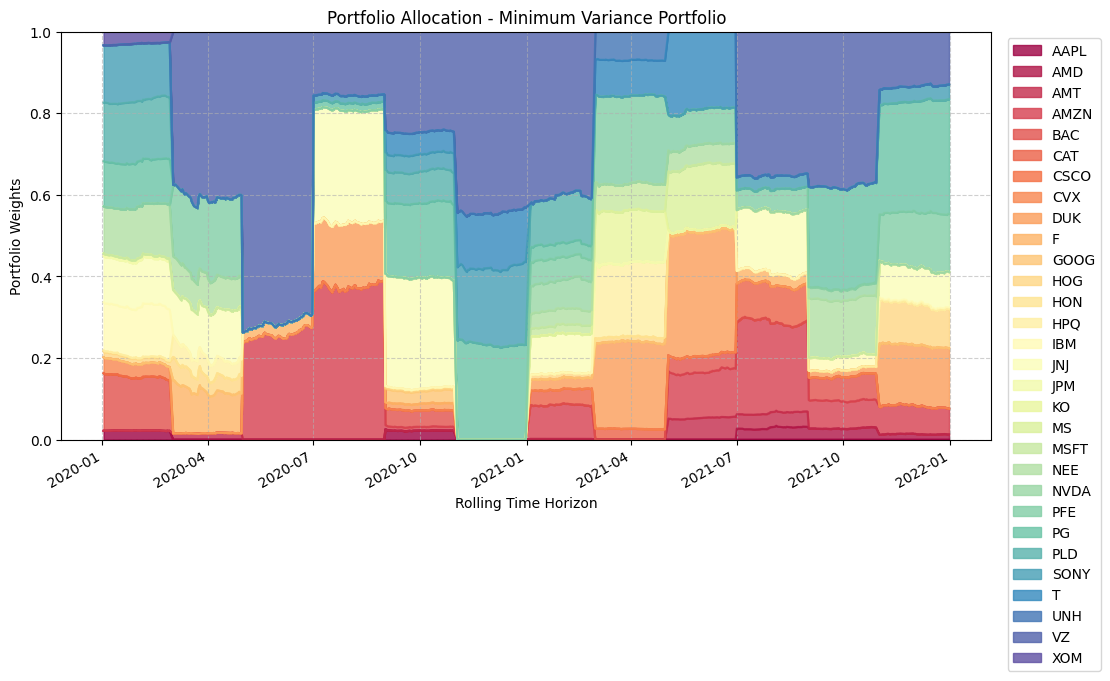

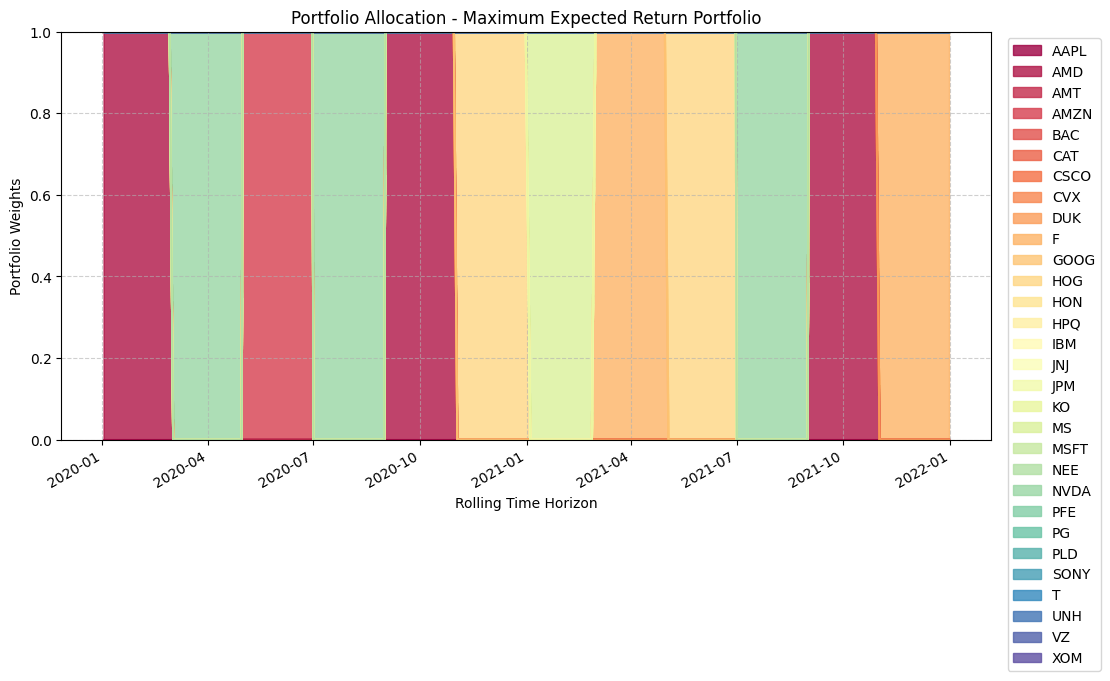

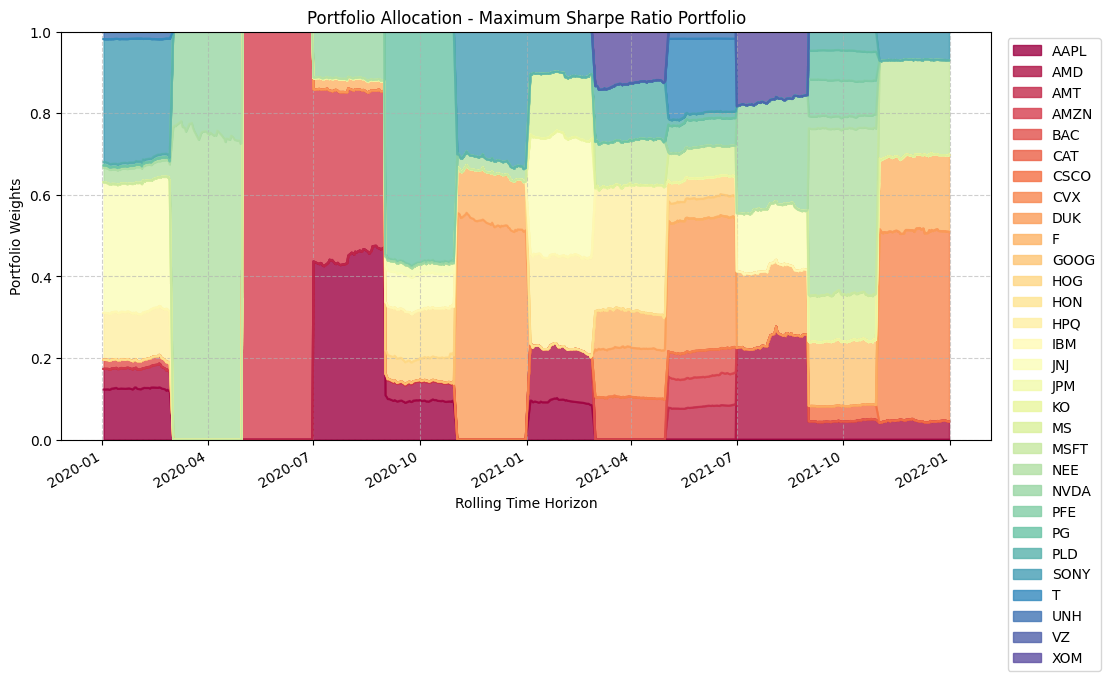

In [22]:

#time_horizon = np.arange(time_periods)
asset_labels = df.columns[1:]


# Convert data into a Pandas DataFrame
df_3 = pd.DataFrame(portfolio_allocation[2], columns=asset_labels, index=dates_array_plot)
df_4 = pd.DataFrame(portfolio_allocation[3], columns=asset_labels, index=dates_array_plot)
df_5 = pd.DataFrame(portfolio_allocation[4], columns=asset_labels, index=dates_array_plot)
# df_5 = pd.DataFrame(strategy_5, columns=asset_labels, index=time_horizon)


# Plot for
plot_pandas_portfolio(df_3, "Minimum Variance Portfolio")

# # Plot for Strategy 4
plot_pandas_portfolio(df_4, "Maximum Expected Return Portfolio")

# # Plot for Strategy 5
plot_pandas_portfolio(df_5, "Maximum Sharpe Ratio Portfolio")


**Compute the risk measures (variance, maximum drawdown, and Sharpe ratio) for the
“Maximum Expected Return” portfolio strategy over the 2020-2021 time period and
compare those to measures for other strategies.**

In [23]:
######variance #####
print("Variance over 2020-2021")
for i in range(len(strategy_functions)):
  print('   Stategy - {0}: {1:.2f}'.format(strategy_functions[i], np.var(portf_value[i]) ))


###### maximum drawdown -> must be the peak coming before trough #####
# MDD = peak - trough / peak
print("Maximum Drawdown (MDD) over 2020-2021")
for i in range(len(strategy_functions)):
  peak = np.maximum.accumulate(portf_value[i]) # the peak portfolio so far
  drawdown = (peak - portf_value[i])/ peak
  print('   Stategy - {0}: {1:.2f}'.format(strategy_functions[i], np.max(drawdown) ))

##### Shape Ratio #####
print("Sharpe Ratio over 2020-2021")

num_trading_days = 252
daily_r_rf= r_rf/num_trading_days

for i in range(len(strategy_functions)):
  reshape_portf_value = portf_value[i].reshape(len(portf_value[i],))
  daily_return_rate = np.diff(reshape_portf_value) / reshape_portf_value[:-1]
  sharpe_ratio = (np.mean(daily_return_rate) - daily_r_rf)/np.std(daily_return_rate) * num_trading_days**0.5
  print('   Stategy - {0}: {1:.2f}'.format(strategy_functions[i], sharpe_ratio) )




Variance over 2020-2021
   Stategy - strat_buy_and_hold: 2632184618.58
   Stategy - strat_equally_weighted: 54444957267.77
   Stategy - strat_min_variance: 11160870476.50
   Stategy - strat_max_return: 128331795595.33
   Stategy - strat_max_Sharpe: 92754872835.84
   Stategy - strat_max_return_sector_constraints: 87276705614.73
Maximum Drawdown (MDD) over 2020-2021
   Stategy - strat_buy_and_hold: 0.22
   Stategy - strat_equally_weighted: 0.34
   Stategy - strat_min_variance: 0.31
   Stategy - strat_max_return: 0.43
   Stategy - strat_max_Sharpe: 0.36
   Stategy - strat_max_return_sector_constraints: 0.31
Sharpe Ratio over 2020-2021
   Stategy - strat_buy_and_hold: -0.11
   Stategy - strat_equally_weighted: 1.02
   Stategy - strat_min_variance: 0.57
   Stategy - strat_max_return: 1.09
   Stategy - strat_max_Sharpe: 1.04
   Stategy - strat_max_return_sector_constraints: 1.01


#Variation of Trading Strategy

In [24]:
# Variation: select “1/n”portfolio at the beginning of period 1 and hold it till the end of period 12
init_period=0
strategy=1

print("Total asset value of Equally Weighted Portfolio strategy: ", portf_value[0][len(portf_value)-1])
# hold the original weight until the end of period 12
total_asset=np.dot(x[strategy, init_period], data_prices[-1]) + cash[strategy, len(cash)-1]
print("Total asset value of holding “1/n” portfolio till the end (12 periods): ", total_asset)

Total asset value of Equally Weighted Portfolio strategy:  [974438.49209595]
Total asset value of holding “1/n” portfolio till the end (12 periods):  1660288.841543572


# Repeat for years 2023-2024

In [25]:
# Input file
# #input_file_prices_new='adjclose_2023_2024.csv' # path to close_2023_2024 file'
# input_file_prices_new='./sample_data/adjclose_2023_2024.csv'

# Read data into a dataframe
# df_new = pd.read_csv(input_file_prices_new)

# Initial positions in the portfolio

init_positions_new = np.array([0, 0, 0, 0, 0, 0, 0, 3542, 0, 0, 0, 10904, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Annual risk-free rate for years 2023-2024 is 4.5%
r_rf2023_2024 = 0.045



In [26]:
# Repeate the previous calculation for the time period 2023-2024
###################### Insert your code here ############################

dates_array = np.array(list(df_new['Date'].apply(convert_date_to_array)))
data_prices = df_new.iloc[:, 1:].to_numpy()
dates = np.array(df_new['Date'])

# Find the number of trading days in Nov-Dec 2021 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
if '2024' in input_file_prices_new:
    day_ind_end0 = len(np.where(dates_array[:,0]==2022)[0])
elif '2025' in input_file_prices_new:
    day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])

cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)
# Remove datapoints for year 2021
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [27]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions_new)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions_new) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)



Initial portfolio value = $ 1000013.01



In [28]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

# weight of each portfolio over time
# portfolio_allocation[i][j][k] is the weight of portfolio k at day j with strategy i
portfolio_allocation = np.zeros((N_strat, N_days, num_stocks),  dtype=np.ndarray)

for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if '2023' in input_file_prices_new:
      if dates_array[0, 0] == 23:
         cur_year  = 23 + math.floor(period/7)
      else:
         cur_year  = 2023 + math.floor(period/7)

   elif '2024' in input_file_prices_new:
      if dates_array[0, 0] == 24:
         cur_year  = 24 + math.floor(period/7)
      else:
         cur_year  = 2024 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]
   #print("cur_prices:", cur_prices)

   # Execute portfolio selection strategies
   for strategy in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions_new
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices, r_rf2023_2024)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0 :
         x[strategy, period-1], cash[strategy, period-1] = handle_insufficient_budget(curr_positions, x[strategy, period-1], cur_prices, cash[strategy, period-1], curr_cash)



      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}, cash account = ${3:.2f}'.format(strategy_names[strategy],
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0], cash[strategy, period-1]))

      # Compute portfolio weight over time

      # Calculate the total worth of each stock on each day
      # divided by total stock worth to get weight
      portfolio_allocation[strategy][day_ind_start:day_ind_end+1] = data_prices[day_ind_start:day_ind_end+1,:]* x[strategy, period-1] / np.reshape(np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]), (p_values.size,1))


   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 01/03/2023, end date 02/28/2023
  Strategy "Buy and Hold", value begin = $ 1000013.01, value end = $ 1028941.58, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 990728.19, value end = $ 1020866.55, cash account = $1882.89
  Strategy "Minimum Variance Portfolio", value begin = $ 990063.60, value end = $ 912216.34, cash account = $195.32
  Strategy "Maximum Expected Return Portfolio", value begin = $ 990062.97, value end = $ 904193.31, cash account = $68.97
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990063.34, value end = $ 901171.59, cash account = $142.36
  Strategy "Maximum Expected Return Portfolio Sector Constraints", value begin = $ 990064.24, value end = $ 1104196.99, cash account = $324.90

Period 2: start date 03/01/2023, end date 04/28/2023
  Strategy "Buy and Hold", value begin = $ 1032531.25, value end = $ 946375.95, cash account = $0.00
  Strategy "Equally Weighted Portfolio", value begin = $ 1014475.76, v

# Plot the results for years 2023-2024

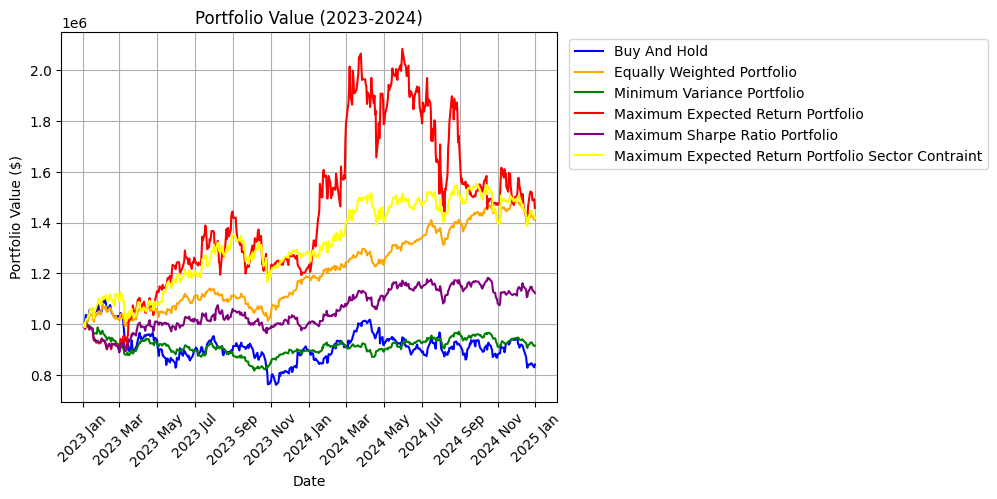

In [29]:
# Plot results for 2023-2024
###################### Insert your code here ############################
dates_array_plot= pd.to_datetime(dates).to_numpy(dtype='datetime64[D]')
plot_portfolio_value(portf_value, dates_array_plot , "(2023-2024)")